New Notebook


In [190]:
import importFunctions as imp 
import kagglehub

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.class_weight import compute_class_weight

import pandas as pd


path = kagglehub.dataset_download("fantineh/next-day-wildfire-spread")
print("Path to dataset files:", path)

train_files = path + "/next_day_wildfire_spread_train*"
test_files = path + "/next_day_wildfire_spread_test*"
eval_files = path + "/next_day_wildfire_spread_eval*"


train = imp.get_dataset(train_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)


eval_data = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

Path to dataset files: C:\Users\theco\.cache\kagglehub\datasets\fantineh\next-day-wildfire-spread\versions\2


In [191]:
#function to plot rows of the train data
def plotRows(start,end,titles,n_features,data):
  inputs, labels = next(iter(data))

  fig = plt.figure(figsize=(15,6.5))

  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

  n_rows = end-start
  for i in range(n_rows):
    for j in range(n_features + 1):
      plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
      if i == 0:
        plt.title(titles[j], fontsize=13)
      if j < n_features - 1:
        plt.imshow(inputs[i+start, :, :, j], cmap='viridis')
      if j == n_features - 1:
        plt.imshow(inputs[i+start, :, :, -1], cmap=CMAP, norm=NORM)
      if j == n_features:
        plt.imshow(labels[i+start, :, :, 0], cmap=CMAP, norm=NORM) 
      plt.axis('off')
  plt.tight_layout()

  plt.show()

In [192]:
titles = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

# plotRows(20,25,titles,len(titles)-1, train)

In [193]:
#gets the train data 
inputs, labels = next(iter(train))

#gets eval data
e_inputs, e_labels = next(iter(eval_data))

#get test data
t_inputs, t_labels = next(iter(test))

In [194]:
#makes the model, keeps it simple

def build_simple_cnn(height,width, features):

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(height, width, features)),
        layers.BatchNormalization(),


        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(1, (1, 1), activation='sigmoid')
    ])

    return model

def build_larger_cnn(height, width, features):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(height, width, features)),
        layers.BatchNormalization(),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        layers.Conv2D(1, (1, 1), activation='sigmoid')
    ])
    return model

In [195]:
#here is the loss functions that I will use

from tensorflow.keras import backend as K



def weighted_bce_loss(y_true,y_pred,weight_nofire=1.0,weight_fire = 10.0):
    """
        Args:
        y_true (Tensor): Ground-truth values
        y_pred (Tensor): Predited values
        weight_nofire (float): Weight of class 0 (no-fire)
        weight_fire (float): Weight of class 1 (fire)
        
    """
    bin_crossentropy = K.binary_crossentropy(y_true, y_pred)

    weights = y_true * weight_fire + (1.0 - y_true) * weight_nofire
    weight_bce = weights * bin_crossentropy

    return K.mean(weight_bce,axis = 1)


def dice_loss(y_true,y_pred):
    BATCH_SIZE = 32
    smooth = 1e-6

    y_true_f = K.reshape(y_true, (BATCH_SIZE, -1))
    y_pred_f = K.reshape(y_pred, (BATCH_SIZE, -1))
    
    intersection = K.sum(y_true_f * y_pred_f, axis=1)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f, axis=1) + K.sum(y_pred_f, axis=1) + smooth)
    

def combined_loss(y_true,y_pred):
    return dice_loss(y_true,y_pred) * .5 + weighted_bce_loss(y_true,y_pred) * .5 

In [196]:
#this removes all the no data points

def shift_data(labels):
    return tf.maximum(labels,tf.constant([0.]))

In [197]:
#TF METRIC VERSION

import tensorflow as tf

def recall_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(tf.where(y_true < 0, 0.0, y_true), tf.float32)

    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    actual_positives = tf.reduce_sum(y_true)

    recall = tf.math.divide_no_nan(true_positives, actual_positives)
    return recall

def precision_m(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(tf.where(y_true < 0, 0.0, y_true), tf.float32)

    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(y_pred)

    precision = tf.math.divide_no_nan(true_positives, predicted_positives)
    return precision

def f1_m(y_true, y_pred):
    prec = precision_m(y_true, y_pred)
    rec = recall_m(y_true, y_pred)
    f1 = tf.math.divide_no_nan(2 * prec * rec, prec + rec)
    return f1


In [198]:
# #METRICS
# def recall_m(y_true,y_pred) -> float:
#     """
#         Args:
#         y_true (Tensor): Ground-truth mask
#         y_pred (Tensor): Mask predicted by model
#     Returns:
#         (float): recall metric value
#     """
#     # y_true = tf.where(y_true < 0, 0, y_true)
#     true_positive = np.sum(np.logical_and(y_true,y_pred))
    

#     actual_positives = np.sum(y_true)

#     if actual_positives == 0:
#         return 1.0
#     else:
#         return true_positive / actual_positives
    

# def precision_m(y_true,y_pred) -> float:
#     """
#         Args:
#         y_true (Tensor): Ground-truth mask
#         y_pred(Tensor): Mask predicted by model
#     Returns:
#         (float): precision metric value
#     """
#     # y_true = tf.where(y_true < 0, 0, y_true)
#     true_positive = np.sum(np.logical_and(y_true,y_pred))

#     pred_positives = np.sum(y_pred)

#     if pred_positives == 0:
#         return 1.0
#     else:
#         return true_positive / pred_positives
    
    
    

# def f1_m(y_true,y_pred) -> float:
#     prec = precision_m(y_true,y_pred)
#     recall = recall_m(y_true,y_pred)

#     return (2*prec*recall)/(prec+recall)



In [199]:
#build the model 
n_fires, height,width, feat_images = inputs.shape

# model = build_segmentation_cnn(height,width,feat_images,2)
model = build_simple_cnn(height,width,feat_images)

labels = shift_data(labels)


model.compile(optimizer = 'adam', 
              loss = combined_loss, 
              metrics = ['accuracy', precision_m, recall_m, f1_m])


In [200]:
#do the fit
n_epoch = 40
history = model.fit(
    inputs,
    labels,
    validation_data = (e_inputs,e_labels),
    epochs = n_epoch,
    batch_size = 16,
    verbose = True

)

Epoch 1/200


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.4541 - f1_m: 0.0525 - loss: 0.9772 - precision_m: 0.0276 - recall_m: 0.5616 - val_accuracy: 0.8126 - val_f1_m: 0.0630 - val_loss: 1.0329 - val_precision_m: 0.0386 - val_recall_m: 0.2076
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5185 - f1_m: 0.0632 - loss: 0.9123 - precision_m: 0.0337 - recall_m: 0.5928 - val_accuracy: 0.9038 - val_f1_m: 0.0254 - val_loss: 1.0885 - val_precision_m: 0.0206 - val_recall_m: 0.0372
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5602 - f1_m: 0.0750 - loss: 0.9007 - precision_m: 0.0400 - recall_m: 0.6159 - val_accuracy: 0.7263 - val_f1_m: 0.0735 - val_loss: 0.8160 - val_precision_m: 0.0408 - val_recall_m: 0.3860
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5655 - f1_m: 0.0737 - loss: 0.8804 - precision_m: 0.0401 - recall_m: 0.6216 - val_accuracy: 0.8998 - val_f1_m: 0.0344 - val_loss: 0.9385 - val_precision_m: 0.0277 - val_recall_m: 0.0506
Epoch 5/200

In [201]:
#plot the training
def plot_training_history(history):
    """
    Plots loss and all other metrics in model history.
    Accepts a `history` object returned by model.fit().
    """
    history_dict = history.history
    metrics = [m for m in history_dict.keys() if not m.startswith('val_') and m != 'loss']
    
    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Plot other metrics
    plt.subplot(1, 2, 2)
    for metric in metrics:
        plt.plot(history.history[metric], label=f'Train {metric}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Metrics over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

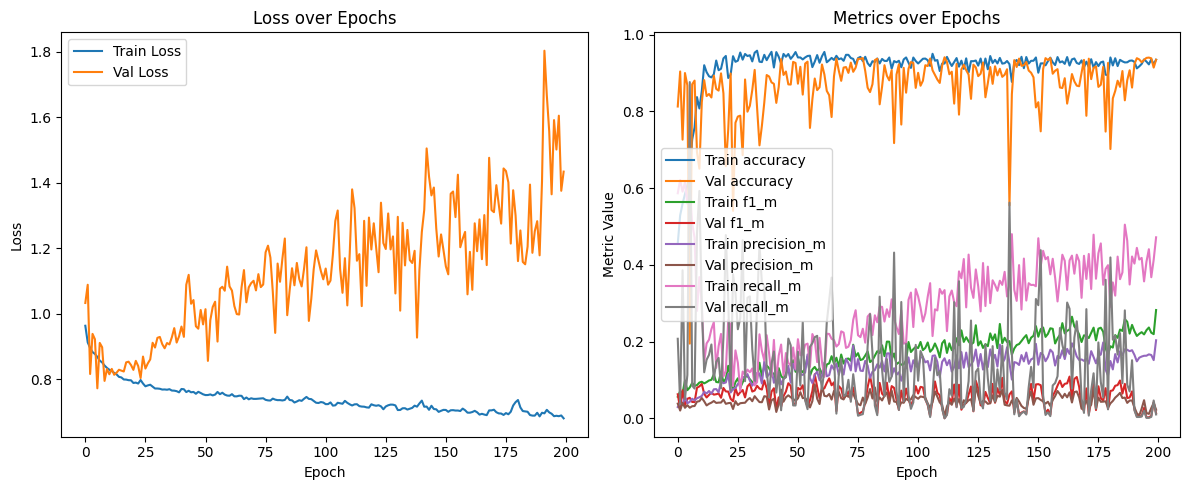

In [202]:
plot_training_history(history)

In [203]:
#plot results


def PlotPredictions(start,end,label,prediction):
  """
  plots pairs of images, one for the actual fire mask, and the next for the predicted firemask from our model.

  Args:
  start (int): the index of the first firemask to use
  end (int): the index of the last fire mask to use, non-inclusive
  label: the actual fire mask
  prediction: the predicted fire mask from the model
  """
    
  n_plots = end - start
  fig, axes = plt.subplots(n_plots, 2, figsize=(12, 4 * n_plots))
  # norm2 = colors.Normalize(vmin=0, vmax=1)  


  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)


  for i in range(n_plots):
    #actual fire mask
    axes[i,0].imshow(label[i+start,:,:,0],cmap=CMAP,norm=NORM)
    axes[i, 0].set_title(f"Actual Fire Mask {i + start} ")
    axes[i, 0].axis('off')

    #handles prediction, each prediction has a vector of [p_noFire,p_fire], we will use whatever one is larger
    axes[i,1].imshow(prediction[start+i,:,:] > .5,cmap=CMAP,norm=NORM)
    axes[i, 1].set_title(f"predicted Fire Mask {i + start}")
    axes[i, 1].axis('off')

  plt.tight_layout()
  plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


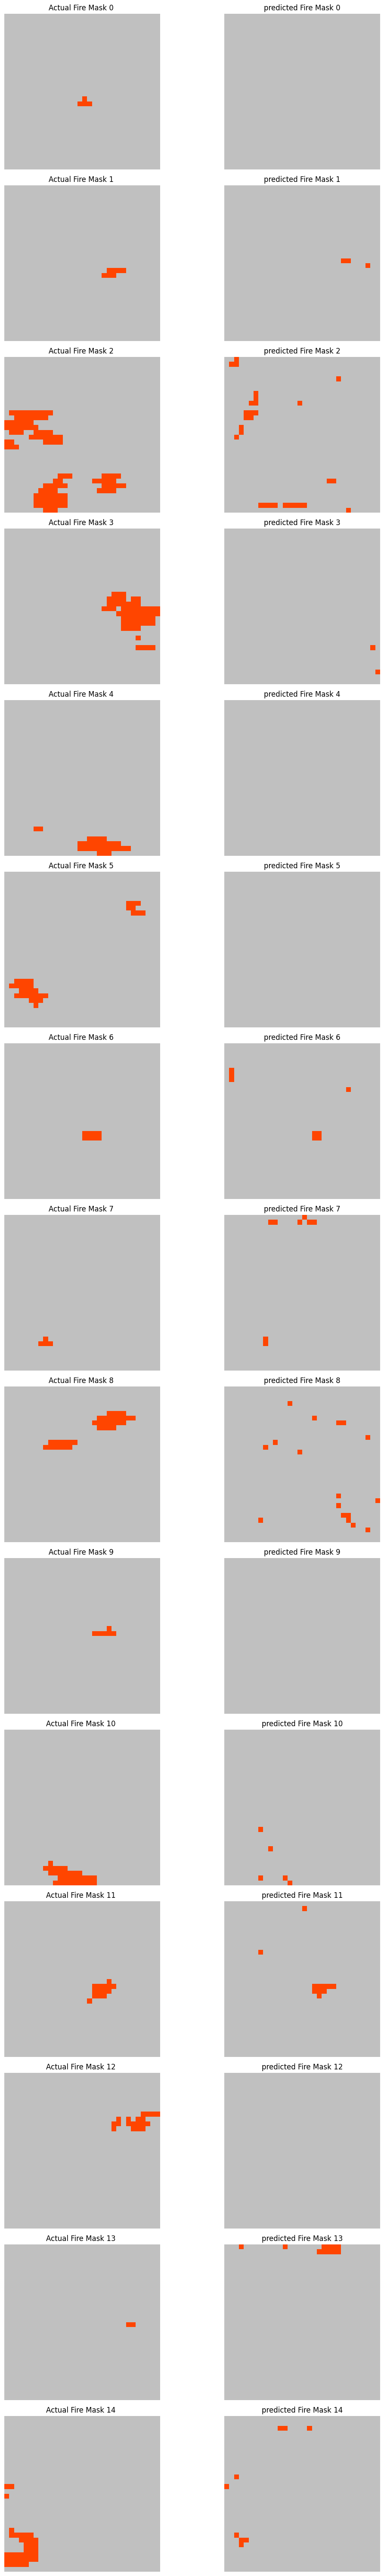

In [204]:
pMask = model.predict(inputs)
pMask_eval = model.predict(e_inputs)


# plotRows(0,5,titles,len(titles)-1, train)
PlotPredictions(0,15,labels,pMask)